In [92]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit,fsolve
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['errorbar.capsize'] = 12
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False


enss=['a24','a']
# enss=['a','b']
ens2full={'a24':'cA211.53.24','a':'cA2.09.48','b':'B64','c':'C80','d':'D96'}
ens2label={'a24':'A24','a':'A48','b':'B64','c':'C80','d':'D96'}
ens2a={'a24':0.0908,'a':0.0938,'b':0.07957,'c':0.06821,'d':0.05692} # fm
ens2N={'a24':24,'a':48,'b':64,'c':80,'d':96}
ens2N_T={'a24':24*2,'a':48*2,'b':64*2,'c':80*2,'d':96*2}

ens2mN={'a':931}
ens2mpiC={'a':131}
ens2mpi0={'a':111}

hbarc = 1/197.3
ens2aInv={ens:1/(ens2a[ens]*hbarc) for ens in enss} # MeV

def fsolve2(func,x0):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res=fsolve(func, x0)[0]
    return res if res!=x0 else np.NaN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
Tpack=24
path='/project/s1174/lyan/code/projectData/NST_f/data/NST_f_cA2.09.48_scattering12.h5'
data=yu.load(path,d=16)
Njk=yu.deepKey(data['2pt'],2).shape[0]

loading: /project/s1174/lyan/code/projectData/NST_f/data/NST_f_cA2.09.48_scattering12.h5
91/91: diags/pi0f-pi0i/opabs                                                        
Ncfg=1228, Njk=76


In [94]:
flags={
    'cc2pt':True, # average quantities related by complex conjugation for 2pt
    'cc3pt':True, # same for 3pt (Removal of vacuum expectation value requires 'cc2pt'=='cc3pt')
    'll2pt':True, # average irrep rows 'l1' and conjugated 'l2' (Parity breaking effect of tmQCD has been taken care of)
    'll3pt':True, # same for 3pt (This flag has no effect if 'll2pt'=True and spin-projection is done)
    'r2pt': True, # making 2ptMat real for the rest frame # 'll2pt' has to be real for this flag
    'remove_pi0VEV':True, 
}

def op_remove_pi0(op):
    t=op.split(';')
    if t[-1] in ['p','n','n,pi+']:
        return False
    if t[3] not in ['N0pi0,a','N1pi0,a']:
        return False
    if t[2] == 'G1u':
        t[2]='G1g'
        assert(t[3]=='N0pi0,a'); t[3]='a'
        assert(t[-1]=='p,pi0'); t[-1]='p'
        return ';'.join(t)

def get2pt_diag(opa,opb,diag):
    opab=f'{opa}_{opb}'
    if opab not in data['2pt'].keys() or diag not in data['2pt'][opab].keys():
        return 0
    res=data['2pt'][opab][diag].copy()
    if not flags['remove_pi0VEV']:
        return res
    if diag == 'pi0f-pi0i':
        if opa==opb and opa=='t;0,0,0;pi0':
            res -= (data['VEV']['pi0f']**2)[:,None]
        return res
    
    if 'pi0f' in diag:
        t_opa=op_remove_pi0(opa)
        if t_opa != False:
            t=diag.split('-'); t.remove('pi0f'); t_diag='-'.join(t)
            res -= data['2pt'][f'{t_opa}_{opb}'][t_diag] * data['VEV']['pi0f'][:,None]
    if 'pi0i' in diag:
        t_opb=op_remove_pi0(opb)
        if t_opb != False:
            t=diag.split('-'); t.remove('pi0i'); t_diag='-'.join(t)
            res -= data['2pt'][f'{opa}_{t_opb}'][t_diag] * np.conj(data['VEV']['pi0f'][:,None])
    if 'pi0f' in diag and 'pi0i' in diag:
        t_opa=op_remove_pi0(opa); t_opb=op_remove_pi0(opb)
        if t_opa != False and t_opb != False:
            t=diag.split('-'); t.remove('pi0f'); t.remove('pi0i'); t_diag='-'.join(t)
            res += data['2pt'][f'{t_opa}_{t_opb}'][t_diag] * data['VEV']['pi0f'][:,None] * np.conj(data['VEV']['pi0f'][:,None])
    return res

def get2pt(opa,opb,diags=yu.diags_all):
    if opa.split(';')[-1]=='12':
        opa1=';'.join(opa.split(';')[:-1]+['n,pi+']); opa2=';'.join(opa.split(';')[:-1]+['p,pi0'])
        return np.sqrt(2/3)*get2pt(opa1,opb,diags)-np.sqrt(1/3)*get2pt(opa2,opb,diags)
    elif opa.split(';')[-1]=='32':
        opa1=';'.join(opa.split(';')[:-1]+['n,pi+']); opa2=';'.join(opa.split(';')[:-1]+['p,pi0'])
        return np.sqrt(1/3)*get2pt(opa1,opb,diags)+np.sqrt(2/3)*get2pt(opa2,opb,diags)
    if opb.split(';')[-1]=='12':
        opb1=';'.join(opb.split(';')[:-1]+['n,pi+']); opb2=';'.join(opb.split(';')[:-1]+['p,pi0'])
        return np.sqrt(2/3)*get2pt(opa,opb1,diags)-np.sqrt(1/3)*get2pt(opa,opb2,diags)
    elif opb.split(';')[-1]=='32':
        opb1=';'.join(opb.split(';')[:-1]+['n,pi+']); opb2=';'.join(opb.split(';')[:-1]+['p,pi0'])
        return np.sqrt(1/3)*get2pt(opa,opb1,diags)+np.sqrt(2/3)*get2pt(opa,opb2,diags)
    
    res=0
    opab=f'{opa}_{opb}'; opba=f'{opb}_{opa}'
    if opab in data['2pt']:
        res+=np.sum([get2pt_diag(opa,opb,diag) for diag in data['2pt'][opab].keys() if diag in diags],axis=0)
    if opba in data['2pt']:
        diags_cc={'T', 'T-pi0f'}; 
        res+=np.conj(np.sum([get2pt_diag(opa,opb,diag) for diag in data['2pt'][opba].keys() if diag in diags_cc and diag in diags],axis=0))
    return res

def get2ptMat(ops,diags=yu.diags_all):
    if flags['ll2pt']:
        flags['ll2pt']=False
        ops_flip=[yu.op_flipl(op) for op in ops]
        t=(get2ptMat(ops,diags=diags)+np.conj(get2ptMat(ops_flip,diags=diags)))/2
        flags['ll2pt']=True
        if ops[0].split(';')[1]=='0,0,0' and flags['r2pt']:
            t=np.real(t)
        return t
    t=np.transpose([[get2pt(opa,opb,diags) for opb in ops] for opa in ops],[2,3,0,1])
    if flags['cc2pt']:
        t=(t+np.conj(np.transpose(t,[0,1,3,2])))/2
    return t


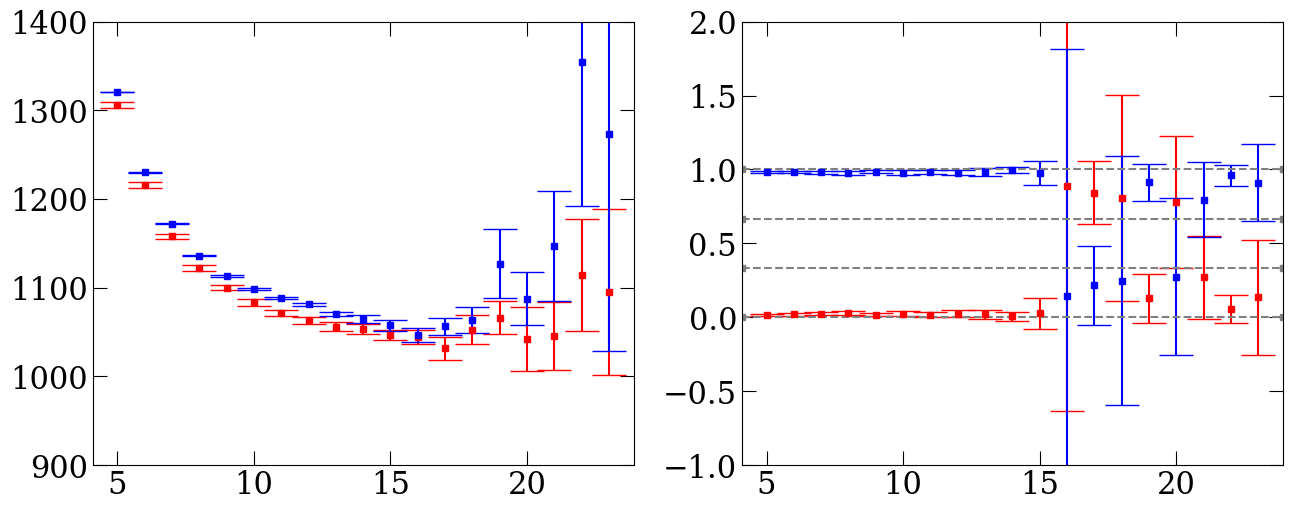

In [147]:
# with GEVP_dt

ens='a'

diags=yu.diags_all
ops=['g;0,0,0;G1u;N0pi0,a;l1;n,pi+','g;0,0,0;G1u;N0pi0,a;l1;p,pi0']
dat=get2ptMat(ops,diags=diags)

GEVP_dt=4
def func(c2ptM):
    evals,evecs=yu.GEVP(c2ptM,-GEVP_dt)
    En=-np.log(evals)/GEVP_dt
    t=np.sqrt(np.abs(evecs[:,:,0])**2 + np.abs(evecs[:,:,1])**2)
    evecs=np.abs(evecs/t[:,:,None])**2
    res=np.concatenate([En,evecs[:,:,0]],axis=1)
    res=np.real(res)
    return res

resGEVP=yu.jackmap(func,dat)
mean,err=yu.jackme(resGEVP)

fig, axs = yu.getFigAxs(1,2,scale=1,sharex=True)
# axs[0,0].set_ylim([0,2*1e5])
xunit=ens2a[ens]

ax=axs[0,0]
tmin=GEVP_dt+1; tmax=24; yunit=ens2aInv[ens]
plt_x=range(tmin,tmax); plt_y=mean[tmin:tmax,0]*yunit; plt_yerr=err[tmin:tmax,0]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='r')
plt_x=range(tmin,tmax); plt_y=mean[tmin:tmax,1]*yunit; plt_yerr=err[tmin:tmax,1]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')
ax.set_ylim(900,1400)

ax=axs[0,1]
tmin=GEVP_dt+1; tmax=24; yunit=1
plt_x=range(tmin,tmax); plt_y=mean[tmin:tmax,2]*yunit; plt_yerr=err[tmin:tmax,2]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='r')
plt_x=range(tmin,tmax); plt_y=mean[tmin:tmax,3]*yunit; plt_yerr=err[tmin:tmax,3]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')
ax.axhline(0,color='grey',linestyle='--')
ax.axhline(2/3,color='grey',linestyle='--')
ax.axhline(1/3,color='grey',linestyle='--')
ax.axhline(1,color='grey',linestyle='--')
ax.set_ylim(-1,2)

None

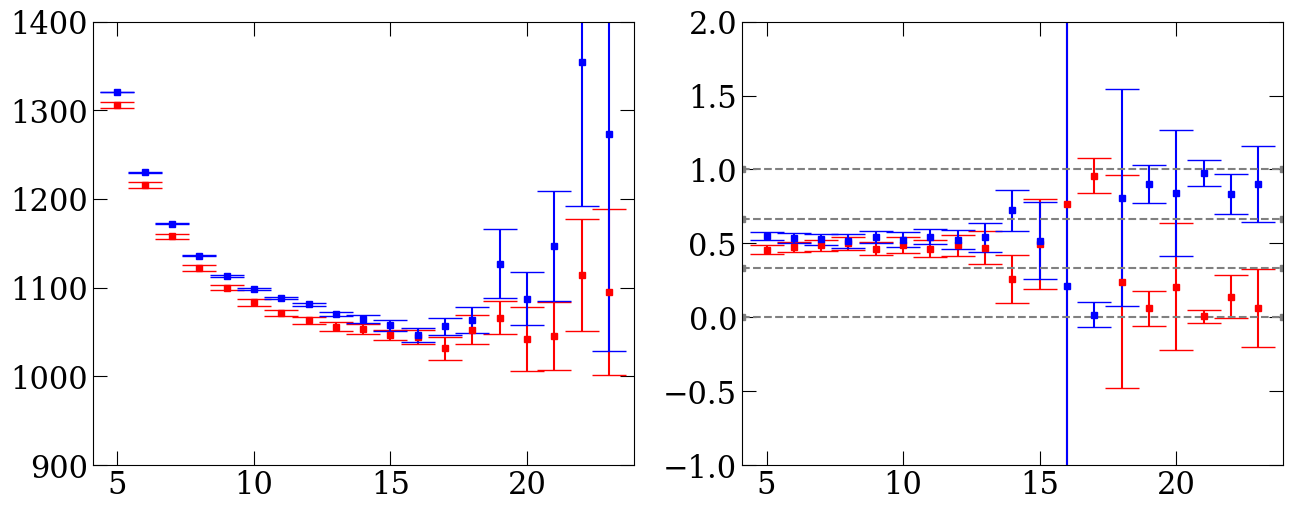

In [148]:
# with GEVP_dt for 1/2 & 3/2 basis

ens='a'

diags=yu.diags_all
ops=['g;0,0,0;G1u;N0pi0,a;l1;12','g;0,0,0;G1u;N0pi0,a;l1;32']
dat=get2ptMat(ops,diags=diags)

GEVP_dt=4
def func(c2ptM):
    evals,evecs=yu.GEVP(c2ptM,-GEVP_dt)
    En=-np.log(evals)/GEVP_dt
    t=np.sqrt(np.abs(evecs[:,:,0])**2 + np.abs(evecs[:,:,1])**2)
    evecs=np.abs(evecs/t[:,:,None])**2
    res=np.concatenate([En,evecs[:,:,0]],axis=1)
    res=np.real(res)
    return res

resGEVP=yu.jackmap(func,dat)
mean,err=yu.jackme(resGEVP)

fig, axs = yu.getFigAxs(1,2,scale=1,sharex=True)
# axs[0,0].set_ylim([0,2*1e5])
xunit=ens2a[ens]

ax=axs[0,0]
tmin=GEVP_dt+1; tmax=24; yunit=ens2aInv[ens]
plt_x=range(tmin,tmax); plt_y=mean[tmin:tmax,0]*yunit; plt_yerr=err[tmin:tmax,0]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='r')
plt_x=range(tmin,tmax); plt_y=mean[tmin:tmax,1]*yunit; plt_yerr=err[tmin:tmax,1]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')
ax.set_ylim(900,1400)

ax=axs[0,1]
tmin=GEVP_dt+1; tmax=24; yunit=1
plt_x=range(tmin,tmax); plt_y=mean[tmin:tmax,2]*yunit; plt_yerr=err[tmin:tmax,2]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='r')
plt_x=range(tmin,tmax); plt_y=mean[tmin:tmax,3]*yunit; plt_yerr=err[tmin:tmax,3]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')
ax.axhline(0,color='grey',linestyle='--')
ax.axhline(2/3,color='grey',linestyle='--')
ax.axhline(1/3,color='grey',linestyle='--')
ax.axhline(1,color='grey',linestyle='--')
ax.set_ylim(-1,2)

None

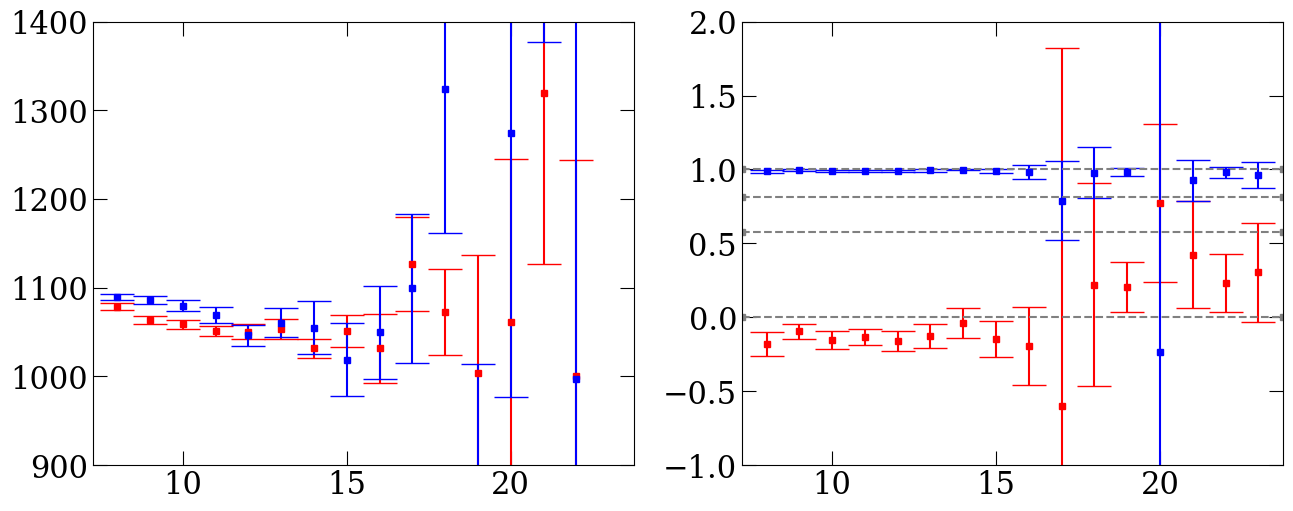

In [128]:
# with GEVP_t0

ens='a'

diags=yu.diags_all
ops=['g;0,0,0;G1u;N0pi0,a;l1;n,pi+','g;0,0,0;G1u;N0pi0,a;l1;p,pi0']
dat=get2ptMat(ops,diags=diags)

GEVP_t0=7
def func(c2ptM):
    evals,evecs=yu.GEVP(c2ptM,GEVP_t0)
    En=np.log(evals/np.roll(evals,-1,axis=0))
    t=np.sqrt(np.abs(evecs[:,:,0])**2 + np.abs(evecs[:,:,1])**2)
    evecs=evecs/t[:,:,None]
    res=np.concatenate([En,evecs[:,:,0]],axis=1)
    res=np.real(res)
    return res

resGEVP=yu.jackmap(func,dat)
mean,err=yu.jackme(resGEVP)

fig, axs = yu.getFigAxs(1,2,scale=1,sharex=True)
# axs[0,0].set_ylim([0,2*1e5])
xunit=ens2a[ens]

ax=axs[0,0]
tmin=GEVP_t0+1; tmax=24; yunit=ens2aInv[ens]
plt_x=range(tmin,tmax); plt_y=mean[tmin:tmax,0]*yunit; plt_yerr=err[tmin:tmax,0]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='r')
plt_x=range(tmin,tmax); plt_y=mean[tmin:tmax,1]*yunit; plt_yerr=err[tmin:tmax,1]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')
ax.set_ylim(900,1400)

ax=axs[0,1]
tmin=GEVP_t0+1; tmax=24; yunit=1
plt_x=range(tmin,tmax); plt_y=mean[tmin:tmax,2]*yunit; plt_yerr=err[tmin:tmax,2]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='r')
plt_x=range(tmin,tmax); plt_y=mean[tmin:tmax,3]*yunit; plt_yerr=err[tmin:tmax,3]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')
ax.axhline(0,color='grey',linestyle='--')
ax.axhline(np.sqrt(2/3),color='grey',linestyle='--')
ax.axhline(np.sqrt(1/3),color='grey',linestyle='--')
ax.axhline(1,color='grey',linestyle='--')
ax.set_ylim(-1,2)

None

In [ ]:
# ploting rn with GEVP_dt

# ens='a'

# diags=yu.diags_all
# ops=['g;0,0,0;G1u;N0pi0,a;l1;n,pi+','g;0,0,0;G1u;N0pi0,a;l1;p,pi0']
# dat=get2ptMat(ops,diags=diags)

# GEVP_dt=4
# def func(c2ptM):
#     evals,evecs=yu.GEVP(c2ptM,-GEVP_dt)
#     En=-np.log(evals)/GEVP_dt
#     t=evecs[:,:,0]
#     evecs=evecs/t[:,:,None]*(-np.sqrt(2))
#     res=np.concatenate([En,evecs[:,:,1]],axis=1)
#     res=np.real(res)
#     return res

# resGEVP=yu.jackmap(func,dat)
# mean,err=yu.jackme(resGEVP)

# fig, axs = yu.getFigAxs(1,2,scale=1,sharex=True)
# # axs[0,0].set_ylim([0,2*1e5])
# xunit=ens2a[ens]

# ax=axs[0,0]
# tmin=GEVP_dt+1; tmax=24; yunit=ens2aInv[ens]
# plt_x=range(tmin,tmax); plt_y=mean[tmin:tmax,0]*yunit; plt_yerr=err[tmin:tmax,0]*yunit
# ax.errorbar(plt_x,plt_y,plt_yerr,color='r')
# plt_x=range(tmin,tmax); plt_y=mean[tmin:tmax,1]*yunit; plt_yerr=err[tmin:tmax,1]*yunit
# ax.errorbar(plt_x,plt_y,plt_yerr,color='b')
# ax.set_ylim(900,1400)

# ax=axs[0,1]
# tmin=GEVP_dt+1; tmax=24; yunit=1
# plt_x=range(tmin,tmax); plt_y=mean[tmin:tmax,2]*yunit; plt_yerr=err[tmin:tmax,2]*yunit
# ax.errorbar(plt_x,plt_y,plt_yerr,color='r')
# plt_x=range(tmin,tmax); plt_y=mean[tmin:tmax,3]*yunit; plt_yerr=err[tmin:tmax,3]*yunit
# ax.errorbar(plt_x,plt_y,plt_yerr,color='b')
# ax.axhline(0,color='black',linestyle='--')
# ax.axhline(1,color='grey',linestyle='--')
# ax.axhline(-2,color='grey',linestyle='--')
# ax.set_ylim(-10,20)
# ax.set_ylim(-5,5)

# None

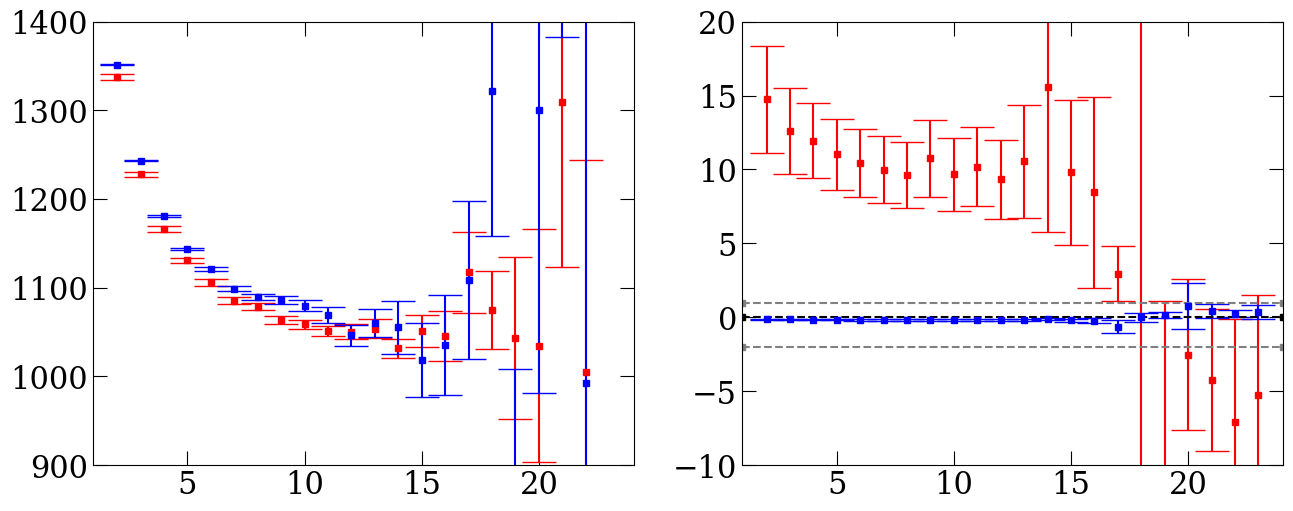

In [ ]:
# ploting rn with GEVP_t0

# ens='a'

# diags=yu.diags_all
# ops=['g;0,0,0;G1u;N0pi0,a;l1;n,pi+','g;0,0,0;G1u;N0pi0,a;l1;p,pi0']
# dat=get2ptMat(ops,diags=diags)

# GEVP_t0=1
# def func(c2ptM):
#     evals,evecs=yu.GEVP(c2ptM,GEVP_t0)
#     En=np.log(evals/np.roll(evals,-1,axis=0))
#     t=evecs[:,:,0]
#     evecs=evecs/t[:,:,None]*(-np.sqrt(2))
#     res=np.concatenate([En,evecs[:,:,1]],axis=1)
#     res=np.real(res)
#     return res

# resGEVP=yu.jackmap(func,dat)
# mean,err=yu.jackme(resGEVP)

# fig, axs = yu.getFigAxs(1,2,scale=1,sharex=True)
# # axs[0,0].set_ylim([0,2*1e5])
# xunit=ens2a[ens]

# ax=axs[0,0]
# tmin=GEVP_t0+1; tmax=24; yunit=ens2aInv[ens]
# plt_x=range(tmin,tmax); plt_y=mean[tmin:tmax,0]*yunit; plt_yerr=err[tmin:tmax,0]*yunit
# ax.errorbar(plt_x,plt_y,plt_yerr,color='r')
# plt_x=range(tmin,tmax); plt_y=mean[tmin:tmax,1]*yunit; plt_yerr=err[tmin:tmax,1]*yunit
# ax.errorbar(plt_x,plt_y,plt_yerr,color='b')
# ax.set_ylim(900,1400)

# ax=axs[0,1]
# tmin=GEVP_t0+1; tmax=24; yunit=1
# plt_x=range(tmin,tmax); plt_y=mean[tmin:tmax,2]*yunit; plt_yerr=err[tmin:tmax,2]*yunit
# ax.errorbar(plt_x,plt_y,plt_yerr,color='r')
# plt_x=range(tmin,tmax); plt_y=mean[tmin:tmax,3]*yunit; plt_yerr=err[tmin:tmax,3]*yunit
# ax.errorbar(plt_x,plt_y,plt_yerr,color='b')
# ax.axhline(0,color='black',linestyle='--')
# ax.axhline(1,color='grey',linestyle='--')
# ax.axhline(-2,color='grey',linestyle='--')
# ax.set_ylim(-10,20)

# None